# Day 11 notebook

The objectives of this notebook are to practice

* deriving substitution matrices
* computing the distribution of random alignment scores

## Modules used in this notebook

In [1]:
import fasta                    # for reading sequences in FASTA format
import collections              # for helpful functions/classes, such as Counter and defaultdict
import math                     # for log
import random                   # for shuffle
import matplotlib.pyplot as plt # for plotting

## Human-Chimp genomic alignment from chromosome 21

In this activity we will analyze a pairwise alignment of a pair orthologous segments of the human and chimpanzee genomes.  This alignment was produced using the [MUMmer](http://mummer.sourceforge.net/) genomic alignment software.  The human segment comes from bases 26727427-26958359 of chromosome 21, and is about 231,000 bases long.  We will first read this alignment from a file `human_chimp_chr21_block.fasta`, which is in FASTA format.

In [2]:
aligned_seqs = fasta.read_sequences_from_fasta_file("human_chimp_chr21_block.fasta")
human_chimp_alignment = [aligned_seq for (seq_name, aligned_seq) in aligned_seqs]

## Deriving a substitution matrix

Your first task to to derive a DNA substitution matrix from the human-chimp alignment described above.  We will break this task down until a number of subtasks.

### PROBLEM 1: Count aligned pairs in an alignment (1 POINT)
The starting point for deriving a substitution matrix from an alignment is to count the number of times you observe each pair of characters aligned to each other.  Write a function below that takes as input an alignment, and returns a dictionary mapping each pair of characters to the number of times that pair is observed in the alignment.

Some details on the implementation:
* You should ignore gapped columns.
* To keep things simple for the later steps, for each column of the alignment that has a pair of characters `(a, b)`, you should add a count for both `(a, b)` and `(b, a)`.  If `a == b`, then that means you will be adding *two* counts for the same pair `(a, a)`.  We will do this so that our substitution matrix is symmetric.
* You do not need to explicity store counts for pairs of characters that are not observed in the matrix (i.e., you do not need to have zeros in your dictionary).


In [3]:
def count_aligned_pairs(alignment):
    """Counts the number times each pair of characters is aligned to each other in an alignment.
    
    Each column in the alignment with an aligned pair (a, b) counts 
    towards both (a, b) and (b, a). Gapped columns are ignored.
    
    Args:
        alignment: a pairwise alignment represented as a list of two strings of equal length
    Returns:
        A dictionary with pairs (tuples) of characters as keys and integer counts as values.
    """   
    ### BEGIN SOLUTION
    aligned_pairs = [pair for pair in zip(*alignment) if '-' not in pair]
    pair_counts = collections.Counter(aligned_pairs)
    pair_counts.update((b, a) for (a, b) in aligned_pairs)
    return pair_counts
    ### END SOLUTION

In [4]:
# tests for count_aligned_pairs
# in case you write a function that includes zeros, this will remove them for testing 
def drop_zeros(count_dict):
    return {key: value for key, value in count_dict.items() if value != 0}

test_align1 = ["CTAGGTAGTCGG",
               "C-ATCTCAATG-"]
test_counts1 = {('A', 'A'): 2, ('A', 'C'): 1, ('A', 'G'): 1, ('A', 'T'): 1,
                ('C', 'A'): 1, ('C', 'C'): 2, ('C', 'G'): 1, ('C', 'T'): 1,
                ('G', 'A'): 1, ('G', 'C'): 1, ('G', 'G'): 2, ('G', 'T'): 1,
                ('T', 'A'): 1, ('T', 'C'): 1, ('T', 'G'): 1, ('T', 'T'): 2}
assert drop_zeros(count_aligned_pairs(test_align1)) == test_counts1

test_align2 = ["AAAACCCCGGGGTTTT",
               "ACGTACGTACGTACGT"]
test_counts2 = {('A', 'A'): 2, ('A', 'C'): 2, ('A', 'G'): 2, ('A', 'T'): 2,
                ('C', 'A'): 2, ('C', 'C'): 2, ('C', 'G'): 2, ('C', 'T'): 2,
                ('G', 'A'): 2, ('G', 'C'): 2, ('G', 'G'): 2, ('G', 'T'): 2,
                ('T', 'A'): 2, ('T', 'C'): 2, ('T', 'G'): 2, ('T', 'T'): 2}
assert drop_zeros(count_aligned_pairs(test_align2)) == test_counts2

print("SUCCESS: count_aligned_pairs passed all tests!")

SUCCESS: count_aligned_pairs passed all tests!


We will now use your `count_aligned_pairs` function on the human chimp alignment.

In [5]:
human_chimp_pair_counts = count_aligned_pairs(human_chimp_alignment)
print(human_chimp_pair_counts)

Counter({('T', 'T'): 143304, ('A', 'A'): 138498, ('C', 'C'): 86782, ('G', 'G'): 86326, ('A', 'G'): 1002, ('G', 'A'): 1002, ('T', 'C'): 874, ('C', 'T'): 874, ('G', 'T'): 262, ('T', 'G'): 262, ('A', 'C'): 261, ('C', 'A'): 261, ('C', 'G'): 227, ('G', 'C'): 227, ('A', 'T'): 213, ('T', 'A'): 213})


### PROBLEM 2: Estimate pair probabilities (1 POINT)
Next, write a function that takes as input a dictionary of aligned character pair counts, and outputs a dictionary of character pair probabilities.  You should use the following equation for the estimates of these probabilities:

$p_{ab} = \frac{A_{ab}}{\sum_{c,d} A_{cd}}$,

where $A_{ab}$ is the count of pair `(a, b)` and the denominator is simply the sum of all pair counts.

In [6]:
def estimate_pair_probs(pair_counts):
    """Estimates the probability of observing each pair of characters in an
    alignment column, given counts of pairs of characters.
    
    Args:
        pair_counts: A dictionary with pairs (tuples) of characters as keys
                     and integer counts as values.
    Returns:
        A dictionary with pairs (tuples) of characters as keys
        and probabilities (floats) as values.
    """   
    ### BEGIN SOLUTION
    n = sum(pair_counts.values())
    return {pair: count / n for pair, count in pair_counts.items()}
    ### END SOLUTION

In [7]:
# tests for estimate_pair_probs
def round_dict(d, digits=5):
    return {key: round(value, digits) for key, value in d.items()}

test_pair_probs1 = {('A', 'A'): 0.1,  ('A', 'C'): 0.05, ('A', 'G'): 0.05, ('A', 'T'): 0.05,
                    ('C', 'A'): 0.05, ('C', 'C'): 0.1,  ('C', 'G'): 0.05, ('C', 'T'): 0.05,
                    ('G', 'A'): 0.05, ('G', 'C'): 0.05, ('G', 'G'): 0.1,  ('G', 'T'): 0.05,
                    ('T', 'A'): 0.05, ('T', 'C'): 0.05, ('T', 'G'): 0.05, ('T', 'T'): 0.1}
assert round_dict(drop_zeros(estimate_pair_probs(test_counts1))) == test_pair_probs1

test_pair_probs2 = {('A', 'A'): 0.0625, ('A', 'C'): 0.0625, ('A', 'G'): 0.0625, ('A', 'T'): 0.0625,
                    ('C', 'A'): 0.0625, ('C', 'C'): 0.0625, ('C', 'G'): 0.0625, ('C', 'T'): 0.0625,
                    ('G', 'A'): 0.0625, ('G', 'C'): 0.0625, ('G', 'G'): 0.0625, ('G', 'T'): 0.0625,
                    ('T', 'A'): 0.0625, ('T', 'C'): 0.0625, ('T', 'G'): 0.0625, ('T', 'T'): 0.0625}
assert round_dict(drop_zeros(estimate_pair_probs(test_counts2))) == test_pair_probs2

print("SUCCESS: estimate_pair_probs passed all tests!")

SUCCESS: estimate_pair_probs passed all tests!


### PROBLEM 3: Estimate character probabilities (1 POINT)
Next, write a function that takes as input a dictionary of aligned character pair counts, and outputs a dictionary of character probabilities.  You should use the following equation for the estimates of these probabilities:

$q_{a} = \frac{\sum_b A_{ab}}{\sum_{c,d} A_{cd}}$

In [8]:
def estimate_char_probs(pair_counts):
    """Estimates the probability of observing each character in a sequence, 
    given counts of pairs of characters.
    
    Args:
        pair_counts: A dictionary with pairs (tuples) of characters as keys
                     and integer counts as values.
    Returns:
        A dictionary with characters as keys and probabilities (floats) as values.
    """   
    ### BEGIN SOLUTION
    n = sum(pair_counts.values())
    char_counts = collections.defaultdict(int)
    for (a, b), count in pair_counts.items():
        char_counts[a] += count
    return {a: count / n for a, count in char_counts.items()}
    ### END SOLUTION

In [9]:
# tests for estimate_char_probs
test_char_probs1 = {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}
assert round_dict(drop_zeros(estimate_char_probs(test_counts1))) == test_char_probs1

test_char_probs2 = {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}
assert round_dict(drop_zeros(estimate_char_probs(test_counts2))) == test_char_probs2

print("SUCCESS: estimate_char_probs passed all tests!")

SUCCESS: estimate_char_probs passed all tests!


Let's examine the character frequencies in the human-chimp alignment:

In [10]:
estimate_char_probs(human_chimp_pair_counts)

{'T': 0.3140615908360617,
 'G': 0.1906628049362988,
 'A': 0.30390283724282874,
 'C': 0.19137276698481073}

What you notice about the character frequencies in the human-chimp alignment?

### BEGIN SOLUTION TEMPLATE=your thoughts here
There is a higher frequency of A and T vs. C and G (i.e., this is an AT-rich region of the genome).  The ratio of C and G to A and T is roughly 3:2.  The frequencies of the complentary bases are roughly the same.  
### END SOLUTION

### PROBLEM 4: Compute a substitution matrix (1 POINT)
Finally, let's put everything together and write a function for computing a substitution matrix from an alignment.  You should use the equation:

$s(a, b) = \log\left(\frac{p_{ab}}{q_a q_b}\right)$

For these computations, use the *natural* logarithm, as provided by the function `math.log` in the `math` module.

In [11]:
def submatrix_from_alignment(alignment):
    """Estimates a substitution matrix from a pairwise sequence alignment.
    
    Args:
        alignment: a pairwise alignment represented as a list of two strings of equal length
    Returns:
        A substitution matri represented as a dictionary with pairs (tuples) of characters
        as keys and substitution scores (floats) as values.
    """
    pair_counts = count_aligned_pairs(alignment)
    p = estimate_pair_probs(pair_counts)
    q = estimate_char_probs(pair_counts)
    ### BEGIN SOLUTION
    return {(a, b): math.log(p[a, b] / (q[a] * q[b])) for a, b in p}
    ### END SOLUTION

In [12]:
# tests for submatrix_from_alignment
test_matrix1 = {('A', 'A'): 0.47,     ('A', 'C'): -0.22314, ('A', 'G'): -0.22314, ('A', 'T'): -0.22314,
                ('C', 'A'): -0.22314, ('C', 'C'): 0.47,     ('C', 'G'): -0.22314, ('C', 'T'): -0.22314,
                ('G', 'A'): -0.22314, ('G', 'C'): -0.22314, ('G', 'G'): 0.47,     ('G', 'T'): -0.22314,
                ('T', 'A'): -0.22314, ('T', 'C'): -0.22314, ('T', 'G'): -0.22314, ('T', 'T'): 0.47}
assert round_dict(submatrix_from_alignment(test_align1)) == test_matrix1

test_matrix2 = {('A', 'A'): 0.0, ('A', 'C'): 0.0, ('A', 'G'): 0.0, ('A', 'T'): 0.0,
                ('C', 'A'): 0.0, ('C', 'C'): 0.0, ('C', 'G'): 0.0, ('C', 'T'): 0.0,
                ('G', 'A'): 0.0, ('G', 'C'): 0.0, ('G', 'G'): 0.0, ('G', 'T'): 0.0,
                ('T', 'A'): 0.0, ('T', 'C'): 0.0, ('T', 'G'): 0.0, ('T', 'T'): 0.0}
assert round_dict(submatrix_from_alignment(test_align2)) == test_matrix2

print("SUCCESS: estimate_char_probs passed all tests!")

SUCCESS: estimate_char_probs passed all tests!


Now let us take a look at the substitution matrix that is derived from the human-chimp alignment:

In [13]:
human_chimp_submatrix = submatrix_from_alignment(human_chimp_alignment)

Below is some code for plotting this substitution matrix.

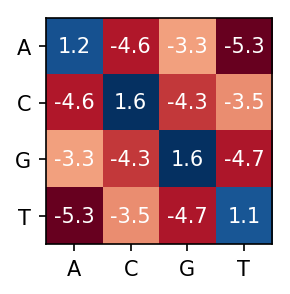

In [14]:
def matrix_from_pair_dict(pair_dict):
    labels = sorted({a for a, b in pair_dict.keys()})
    matrix = [[pair_dict[a, b] for b in labels] for a in labels]
    return labels, matrix

def plot_submatrix(submatrix):
    labels, matrix = matrix_from_pair_dict(submatrix)
    plt.figure(figsize=(2, 2), dpi=150)
    plt.imshow(matrix, cmap="RdBu")
    label_indices = list(range(len(labels)))
    plt.xticks(label_indices, labels)
    plt.yticks(label_indices, labels)
    for i in label_indices:
        for j in label_indices:
            plt.text(j, i, round(matrix[i][j], 1),
                     ha="center", va="center", color="w")
    plt.show()
    
plot_submatrix(human_chimp_submatrix)

What do you notice about this substitution matrix?  Noting that `A` and `G` are both *purine* bases and that `C` and `T` are both *pyrimadine* bases, is there anything interesting about this matrix?

### BEGIN SOLUTION=Your thoughts here
The scores for transition events (mutating from purine to purine or from pyrimadine to pyrimadine) are higher (less of a penalty) than those for transversion events (mutating from purine to pyrimadine or vice versa).  This indicates that transitions are more frequent than transversions in the human and chimp genomes.  Also, the match scores for C and G are higher than those for A and T, mostly because the frequency of A and T is higher.
### END SOLUTION

## Distribution of the scores of local alignments between random sequences

### PROBLEM 5: Best ungapped local alignment score (1 POINT)
We will examine the distribution of scores of ungapped local alignments between a pair of random (unrelated) sequences.  To do this we will need a function to find the best score of an ungapped local alignment between a pair of sequences.  This can be accomplished via a simplified version of the Smith–Waterman algorithm.  Since we will not allow gaps in alignments, the recurrence for the algorithm simply becomes:

$M[i, j] = \max \left\{\begin{array}{l}
0, \\
M[i - 1, j - 1] + s(x_i, y_j)
\end{array}
\right.$

Complete the implementation of the function below to compute the best score of an ungapped local alignment between a pair of sequences, `x` and `y`, with the substitution matrix, `submatrix`.

In [15]:
def matrix(num_rows, num_cols, initial_value):
    """Returns a matrix (a list of rows, each of which is a list) 
    with num_rows and num_cols and with initial_value in each entry"""
    return [[initial_value] * num_cols for i in range(num_rows)]

def best_ungapped_local_alignment_score(x, y, submatrix):
    """Computes the score of the best ungapped local alignment between two sequences.
    
    Args:
        x: a string representing the first sequence
        y: a string representing the second sequence
        submatrix: a substitution matrix represented as dictionary
    Returns:
        The score of the best ungapped local alignment.
    """    
    # construct a dynamic programming matrix
    m = matrix(len(x) + 1, len(y) + 1, 0)
    # initialization is zeros in first row and first column, which is already done
    # now we do the main fill stage of the rest of the entries
    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            ### BEGIN SOLUTION
            m[i][j] = max(0, m[i - 1][j - 1] + submatrix[x[i - 1], y[j - 1]])
            ### END SOLUTION
    return max(map(max, m))

In [16]:
# tests for best_ungapped_local_alignment_score
test_matrix3 = {('A', 'A'): 1.0, ('A', 'C'): -5.0, ('A', 'G'): -3.0, ('A', 'T'): -5.0,
                ('C', 'A'): -5.0, ('C', 'C'): 2.0, ('C', 'G'): -4.0, ('C', 'T'): -3.0,
                ('G', 'A'): -3.0, ('G', 'C'): -4.0, ('G', 'G'): 2.0, ('G', 'T'): -5.0,
                ('T', 'A'): -5.0, ('T', 'C'): -3.0, ('T', 'G'): -5.0, ('T', 'T'): 1.0}
assert best_ungapped_local_alignment_score("TCTGA", "GATG", test_matrix3) == 3.0
assert best_ungapped_local_alignment_score("TGA", "TTAG", test_matrix3) == 2.0
assert best_ungapped_local_alignment_score("TGA", "TTGAA", test_matrix3) == 4.0
assert best_ungapped_local_alignment_score("TGC", "AAA", test_matrix3) == 0.0
assert best_ungapped_local_alignment_score("TGACTAGGACTTAGC", "AACATGACTGGGACTGAATGCA", test_matrix3) == 12.0
print("SUCCESS: best_ungapped_local_alignment_score passed all tests!")

SUCCESS: best_ungapped_local_alignment_score passed all tests!


### Generate a large set of best ungapped local alignment scores between pairs of random sequences
Use your `best_ungapped_local_alignment_score` function to compute the best ungapped local alignment score for a large number (say 2000) of random pairs of sequences.  To keep runtime manageable, make your sequences 100 bases each.  Use your human-chimp substitution matrix, or the `test_matrix3` in the testing cell above.  You may find the `shuffle_seq` function below of use.

In [17]:
def shuffle_seq(s):
    """Returns a new string that is a randomly shuffled version of the input string.
    
    Args:
        s: a string
    Returns:
        A string with the same characters as the input string but in a random order
    """      
    s_list = list(s)
    random.shuffle(s_list)
    return ''.join(s_list)

In [18]:
### BEGIN SOLUTION
query = "A" * 25 + "C" * 25 + "G" * 25 + "T" * 25
random_scores = [best_ungapped_local_alignment_score(shuffle_seq(query), shuffle_seq(query), test_matrix3)
                 for i in range(2000)]
### END SOLUTION

Plot the distribution of your set of scores between random sequences using `pyplot.hist` below:

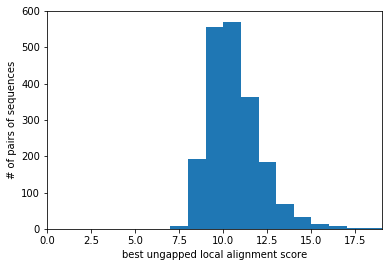

In [19]:
### BEGIN SOLUTION
plt.hist(random_scores, bins=range(0, int(max(random_scores)) + 1))
plt.xlim(0, max(random_scores))
plt.xlabel("best ungapped local alignment score")
plt.ylabel("# of pairs of sequences")
plt.show()
### END SOLUTION

Compare your distribution above with the theoretical distribution, which is a form of a *extreme value distribution*.  The function below gives the density of this distribution.  The parameter `N` should be the number of possible starting points for an ungapped local alignment, which is $n^2$ for two sequences of the same length $n$.

In [20]:
def evd(x, N):
    """Returns the density of the extreme value distribution at x, with parameter N."""
    return N * math.exp(-N * math.exp(-x) - x)

In the cell below, plot a the density of the extreme value distribution to see how well is matches with the distribution from the random scores.  To do so, evaluate the `evd` at a range of values of `x` spanning the range of scores found from aligning random pairs of sequences.

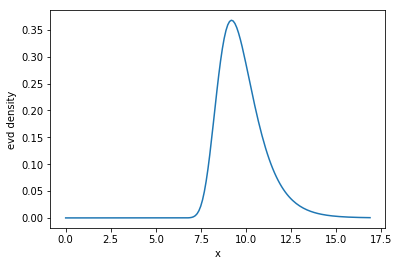

In [21]:
### BEGIN SOLUTION
evd_x = [x / 10 for x in range(0, 170)]
evd_y = [evd(x, len(query) * len(query)) for x in evd_x]
plt.plot(evd_x, evd_y)
plt.xlabel("x")
plt.ylabel("evd density")
plt.show()
### END SOLUTION